In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import hickle
from ase.units import Hartree
from ase.io import read
from ase.visualize import view
import ase

In [6]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations
from equistore_utils.clebsh_gordan import ClebschGordanReal
from equistore_utils.mp_utils import  *
from equistore_utils.acdc_mini import acdc_standardize_keys
from equistore import Labels, TensorBlock, TensorMap
from itertools import product
import torch

In [7]:
hypers = {
    "cutoff": 2.0,
    "max_radial": 6,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
cg = ClebschGordanReal(6)

calculator = SphericalExpansion(**hypers)

def compute_rho3(frames):
    rhoi = calculator.compute(frames)
    rhoi = rhoi.keys_to_properties(['species_neighbor'])
    rho1i = acdc_standardize_keys(rhoi)
    # selects only one environment
    rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
    rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
    rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])
    
    raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    ])
#     print(raw.shape)
#     hickle.dump (raw, feat_file+ 'feat_123.hickle')
#     feats = PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) 
#     hickle.dump(feats, feat_file + 'feat_123_PCA.hickle')
    
    return raw

def compute_3c(frames, return_3c = False):
    from sklearn.decomposition import PCA
    calculator = SphericalExpansion(**hypers)
    rhoi = calculator.compute(frames)
    rhoi = rhoi.keys_to_properties(['species_neighbor'])
    rho1i = acdc_standardize_keys(rhoi)

    # selects only one environment
    rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )

    calculator = PairExpansion(**hypers)
    gij = calculator.compute(frames)
    gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
    gij =  acdc_standardize_keys(gij)


    rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
    rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)
    raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(),rhoii1i2_nu1.block(1).values.squeeze()])
    #print(raw.shape)
    feats_n2nu1 = PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw)

    if return_3c:
        return feats_n2nu1, rhoii1i2_nu1
    else:
        return feats_n2nu1

In [8]:
def rmsd_atomic_positions(x, y):
    """
    Calculate the Root Mean Square Deviation (RMSD) between two sets of atomic positions.
    """
#     return np.sqrt(np.mean(np.sum((x-y)**2, axis=1)))
    return np.sqrt(np.sum((x-y)**2, axis=(1,2))/(8*3))
    


In [27]:
fr1 = read('/Users/jigyasa/scratch/bispectrum_counter/boron/NOISE/symm/boron8_distorted_frames_var1e-4.xyz', ':1000')
rho3i = compute_rho3(fr1)
rho3i_deg = compute_rho3(frames[:1000])

rho33 = np.vstack((rho3i_deg, rho3i))
rho33=rho33/np.linalg.norm(rho33)

In [39]:
rho3i = hickle.load('feat_123_PCA.hickle')[:300]
rho3i=rho3i/np.linalg.norm(rho3i)
rho3i+= np.random.normal(0,1e-3,rho3i.shape)
rho33 = hickle.load('NOISE1feat_123_PCA.hickle')[:300]
rho33=rho33/np.linalg.norm(rho33)
rho33 = np.vstack((rho3i, rho33))
pair_bis = []
for i in range(300):
    for j in range(i, 300):
        pair_bis.append(np.linalg.norm(rho33[i] - rho33[j]))
        
        
rho33 = hickle.load('NOISE1feat_123_PCA.hickle')[300:600]
# rho33=rho33/np.linalg.norm(rho33)


# for i in range(0,len(frames),2):
#     noise = np.random.normal(0,1e-4,(1,rho3i.shape[-1]))
#     rho3i[i:i+2]+noise


pair_bis5 = []
for i in range(300):
    for j in range(i, 300):
        pair_bis5.append(np.linalg.norm(rho33[i] - rho33[j]))

In [31]:
# np.save('extra1-1rho33.npy', rho33)
# np.save('extra1-1pair_rho33', pair_rho33)

# np.save('extra1-1pair_rho33-500', pair_rho33)

In [40]:
# f3ci = compute_3c(fr1)
# f3c_deg = compute_3c(frames[:1000])
enc = hickle.load('nl_encoded_feat.hickle')[:300]
enc+= np.random.normal(0,1e-3,enc.shape)
enc = enc/np.linalg.norm(enc)

enc33 = hickle.load('NOISE1nl_encoded_feat.hickle')[:300]
enc33 = enc33/np.linalg.norm(enc33)
enc33 = np.vstack((enc, enc33))

pair_enc_nl = []
for i in range(300):
    for j in range(i, 300):
        pair_enc_nl.append(np.linalg.norm(enc33[i] - enc33[j]))


        
enc33 = hickle.load('NOISE1nl_encoded_feat.hickle')[300:600]
# enc33 = enc33/np.linalg.norm(enc33)

pair_enc_nl5 = []
for i in range(300):
    for j in range(i, 300):
        pair_enc_nl5.append(np.linalg.norm(enc33[i] - enc33[j]))


In [41]:
f7 = hickle.load('feat_1234567_PCA.hickle')[:300]
f7+= np.random.normal(0,1e-3,f7.shape)
f7 = f7/np.linalg.norm(f7)
f733 = hickle.load('NOISE1feat_1234567_PCA.hickle')[:300]
f733 = f733/np.linalg.norm(f733)
f733 = np.vstack((f7, f733))

pair_f7_nl = []
for i in range(0, 300):
    for j in range(i, 300):
        pair_f7_nl.append(np.linalg.norm(f733[i]-f733[j]))

# np.save('extra1-1pair_f733', pair_f733)

f733 = hickle.load('NOISE1feat_1234567_PCA.hickle')[300:600]
f733 = f733/np.linalg.norm(f733)
# f733 = np.vstack((f7, f733))
pair_f7_nl5 = []
for i in range(0, 300):
    for j in range(i, 300):
        pair_f7_nl5.append(np.linalg.norm(f733[i]-f733[j]))
        
# np.save('extra1-1pair_f733-500', pair_f733)

In [156]:
pair_enc33 = []
for i in range(500):
    for j in range(i, 500):
        pair_enc33.append(np.linalg.norm(enc33[i] - enc33[j]))

NameError: name 'enc33' is not defined

In [209]:
np.save('1-1enc33.npy', enc33)
np.save('1-1pair_enc33', pair_enc33)

NameError: name 'enc33' is not defined

In [21]:
rho3i.shape

(1000, 5118)

# REVISION 

In [5]:
import torch
import hickle

In [6]:
# def rmsd(x, nfeats = 1):
#     return torch.sqrt(torch.mean(torch.sum((x[0::2] - x[1::2])**2, axis=1)/nfeats))

In [70]:
def scale(x, var=False): 
    if not var:
        return x-x.mean()
    else: 
        return (x-x.mean)/np.std(x)
#         pass

def distort(x, var= 1e-3, scale = 1): 
    noise = np.random.normal(0,var, x.shape )*scale 
    print(np.linalg.norm(noise), np.linalg.norm(x))
    return x + noise, noise


In [94]:
enc_nl = hickle.load('/Users/jigyasa/scratch/bispectrum_counter/boron/nl_encoded_feat.hickle').numpy()
enc_nl, noise = distort(enc_nl, scale=1e-2)
enc_nl = enc_nl/np.linalg.norm(enc_nl)

# enc_lin = hickle.load('/Users/jigyasa/scratch/bispectrum_counter/boron/lin_encoded_feat.hickle').numpy()
# feat7 = hickle.load('/Users/jigyasa/scratch/bispectrum_counter/boron/feat_1234567_PCA.hickle')

bisp = hickle.load('/Users/jigyasa/scratch/bispectrum_counter/boron/feat_123.hickle')
bisp, noise= distort(bisp,var=1e-2)#, scale=1e-7)
bisp=bisp/np.linalg.norm(bisp)
# f3c = hickle.load('/home/nigam/scratch/MAC/bispectrum_counter/boron/f3c_dist_pairwise.npy')

# enc_nl+=noise
# enc_nl = enc_nl/np.linalg.norm(enc_nl)

# energy = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/energy.npy')*Hartree 

0.010123325332083632 60378.84514994012
63.98478562545987 105.68701782670782


In [48]:
# pair_bis = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1pair_rho33.npy')
# pair_enc_nl = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/1pair_enc33.npy')

pair_bis = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1-1pair_rho33.npy')
pair_enc_nl = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1-1pair_enc33.npy')

pair_bis5 = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1-1pair_rho33-500.npy')[:2000]
pair_enc_nl5 = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1-1pair_enc33-500.npy')[:2000]

pair_f7_nl = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1-1pair_f733.npy')
pair_f7_nl5 = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/extra1-1pair_f733-500.npy')[:2000]

In [29]:
np.random.normal(scale = 1e-6)

1.237355196960946e-07

In [ ]:
pair_bis[np.where(pair_bis<1e-10)]+=np.random.rand(1e-4)

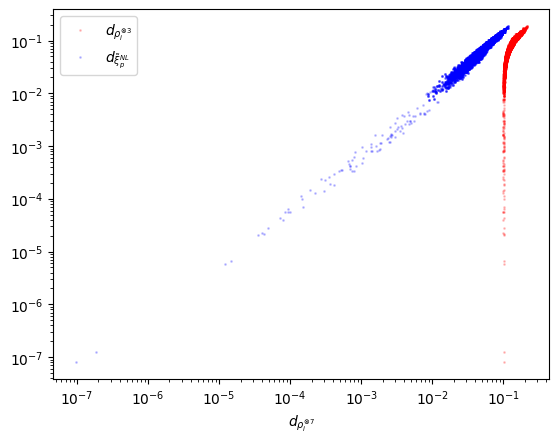

In [49]:
# plt.loglog(pair_enc_nl, pair_bis, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2)
# plt.loglog(pair_enc_nl5, pair_bis5, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2)
plt.loglog(pair_bis, pair_f7_nl,  c='r', ls = '', marker = 'o', markersize =1, alpha=0.2, label = r'$d_{\rho_i^{\otimes{3}}}$')
plt.loglog( pair_enc_nl,  pair_f7_nl, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2, label = r'$d_{\tilde{\xi}_p^{NL}}$')
#            =\sum_{i_1,i_2}\psi_p^{NL}[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$')

# plt.loglog(pair_enc_nl5, pair_bis5, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2)
# plt.loglog(pair_enc_nl5, pair_bis5, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2)

# plt.loglog( pair_enc_nl5, pair_f7_nl5, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2)
# plt.loglog(pair_bis5, pair_f7_nl5, c='r', ls = '', marker = 'o', markersize =1, alpha=0.2)

plt.xlabel(r'$d_{\rho_i^{\otimes{7}}}$')

# plt.ylabel(r'$| \rho_i^{\otimes{3}}\rangle $')
# plt.ylim([5e-3, 4e-1])
# plt.xlim([5e-3, 4e-1])
plt.legend()

In [137]:
print(np.max(pair_enc_nl), np.max(pair_bis))

0.025998541528369633 0.021772992144079267


In [4]:
pair_bis = np.load('bis_allpairs_norm_noisy.npy')
pair_enc_nl = np.load('enc_nl_allpairs_norm_noisy.npy')

In [103]:
# np.save('bis_allpairs_norm_noisy', pair_bis)

In [104]:
# np.save('enc_nl_allpairs_norm_noisy', pair_enc_nl)

In [80]:
len(pair_enc_nl)

32004000

In [8]:
pair_enc_nl = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/enc_nl_allpairs_norm.npy')
# enc_lin = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/enc_lin_allpairs.npy')
pair_bis  = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/bis_allpairs_norm.npy')
# f7 = np.load('/Users/jigyasa/scratch/bispectrum_counter/boron/feat7_allpairs.npy')

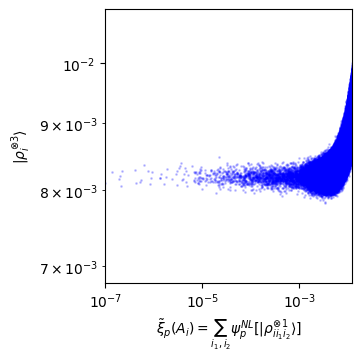

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)
ax.loglog(pair_enc_nl, pair_bis, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2)
ax.set_xlabel(r'$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p^{NL}[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$')
ax.set_ylabel(r'$| \rho_i^{\otimes{3}}\rangle $')
ax.plot()
ax.set_xlim(1e-7,1.2e-1)
ax.set_ylim(7.8e-3,1.1e-2)

# ax.axline((0,0), slope=1, color='black')
# ax.legend()
fig.savefig("boron-sensitivity.pdf")

In [27]:
# enc_nl = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/encoded_nl_dist_pairwise.npy')
# enc_lin = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/encoded_lin_dist_pairwise.npy')
# feat7 = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/feat7_dist_pairwise.npy')
# bisp = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/bis_dist_pairwise.npy')
# f3c = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/f3c_dist_pairwise.npy')


# energy = np.load('Users/jigyasa/scratch/bispectrum_counter/boron/energy.npy')*Hartree 

In [41]:
# enc_nl_mean = np.load('/home/nigam/scratch/MAC/bispectrum_counter/boron/encoded_nl_mean_pairwise.npy')
# enc_lin_mean = np.load('/home/nigam/scratch/MAC/bispectrum_counter/boron/encoded_lin_mean_pairwise.npy')
# feat7_mean = np.load('/home/nigam/scratch/MAC/bispectrum_counter/boron/feat7_mean_pairwise.npy')
# bisp_mean = np.load('/home/nigam/scratch/MAC/bispectrum_counter/boron/bis_mean_pairwise.npy')
# f3c_mean= np.load('/home/nigam/scratch/MAC/bispectrum_counter/boron/f3c_mean_pairwise.npy')

# SUBMISSION 

In [112]:
def get_mean_error(predictions, target):
    first = (predictions[::2] + predictions[1::2]).flatten() / 2.0
    second = (target[::2] + target[1::2]).flatten() / 2.0
    values = first - second
    error = np.sqrt(np.mean(values ** 2))
    return error 

def get_delta_error(predictions, target):
    first = (predictions[::2]-predictions[1::2]).flatten()
    second = (target[::2]-target[1::2]).flatten()
    values = first - second
    error = np.sqrt(np.mean( values ** 2 ))   
    return error

def get_all_errors(predictions_train, predictions_val, target_train, target_val, relative=True):
#     target_full = np.concatenate([target_train, target_val], axis = 0)
    print("target_train.shape", target_train.shape)
    print("target_val.shape", target_val.shape)
    mean_error_train = get_mean_error(predictions_train, target_train)
    mean_error_val = get_mean_error(predictions_val, target_val)
    delta_error_train = get_delta_error(predictions_train, target_train)
    delta_error_val = get_delta_error(predictions_val, target_val)
#     normalization_mean = np.std(target_full)
    normalization_mean_train = np.std(target_train)
    normalization_mean_val = np.std(target_val)
    norm_delta_train = np.std(target_train[::2] - target_train[1::2])
    norm_delta_val = np.std(target_val[::2] - target_val[1::2])
#     normalization_delta = np.std(target_full[::2]-target_full[1::2])
    if relative:
        print("normalized")
#         print("mean_train", normalization_mean_train)
#         print("mean_test", normalization_mean_val)
#         print("delta_train", norm_delta_train)
#         print("delta_test", norm_delta_val)
        mean_error_train = mean_error_train / normalization_mean_train#normalization_mean
        mean_error_val = mean_error_val / normalization_mean_val#normalization_mean
        delta_error_train = delta_error_train / norm_delta_train#normalization_delta
        delta_error_val = delta_error_val / norm_delta_val#normalization_delta 
        
    return mean_error_train, mean_error_val, delta_error_train, delta_error_val



In [113]:
# from ase.visualize import view 
# frames = read('bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz', ':8000')
from ase.io import write

In [114]:
# write('frame-354.xyz', frames[354])
# write('frame-355.xyz', frames[355])

# BORON

## Features

In [ ]:
feats_nu_to7 = hickle.load('bispectrum_counter/boron/feat_1234567_PCA.hickle')
output_size = feats_nu_to7.shape[-1]
target = feats_nu_to7[:,:output_size]
ntrain = 7000

### linear 

In [ ]:
pred_lin = np.load('bispectrum_counter/boron/pred_feat/silu_lin8k.npy')

In [56]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], feats_nu_to7[:7000], feats_nu_to7[7000:])
print("mean train error: ",lin_mean_train )
print("mean test error: ",lin_mean_val )
print("delta train error: ",lin_delta_train )
print("delta val train error: ",lin_delta_val )


target_train.shape (7000, 8000)
target_val.shape (1000, 8000)
normalized
mean train error:  0.009852770000171917
mean test error:  0.017416600517321922
delta train error:  1.0000000010279626
delta val train error:  1.0000000031103427


0.011056593343501751 1.0000536525794215


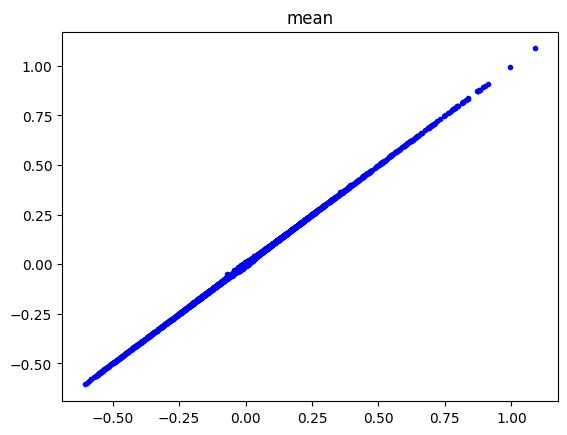

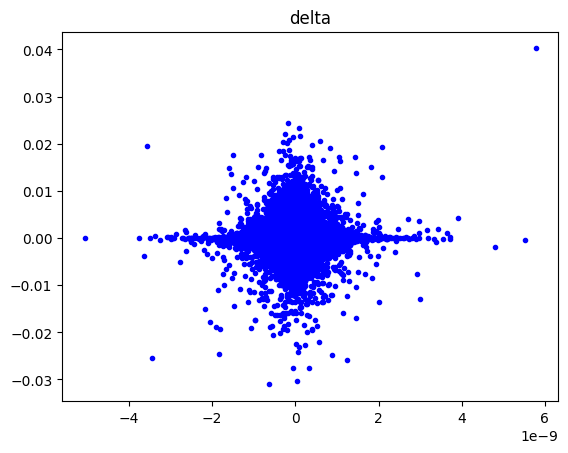

In [19]:
plt.plot((pred_lin[::2]+pred_lin[1::2])[ntrain//2:]/2, (target[::2]+target[1::2])[ntrain//2:]/2,'b.')
plt.title("mean")
plt.figure()
plt.plot((pred_lin[::2]-pred_lin[1::2])[ntrain//2:], (target[::2]-target[1::2])[ntrain//2:],'b.')
plt.title('delta')
print( 
    np.sqrt(np.mean( ((pred_lin[::2]+pred_lin[1::2]).flatten()[ntrain//2:]/2-(target[::2]+target[1::2]).flatten()[ntrain//2:]/2)**2 )) /np.std(target)
    ,
    np.sqrt(np.mean( ((pred_lin[::2]-pred_lin[1::2]).flatten()[ntrain//2:]-(target[::2]-target[1::2]).flatten()[ntrain//2:])**2 )) /np.std(target[::2]-target[1::2])     
     )

### non-linear

In [3]:
pred_nl = np.load('bispectrum_counter/boron/pred_feat/silu_nl8k.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'bisp/pred_feat/silu_nl8k.npy'

In [23]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], feats_nu_to7[:7000], feats_nu_to7[7000:])

print("mean train error: ",nl_mean_train )
print("mean test error: ",nl_mean_val )
print("delta train error: ",nl_delta_train )
print("delta val train error: ",nl_delta_val )

target_train.shape (7000, 8000)
target_val.shape (1000, 8000)
mean train error:  0.004352581283773807
mean test error:  0.006698606461081356
delta train error:  0.125429454333545
delta val train error:  0.14332104851049665


0.004700671671458836 0.12762845331134298


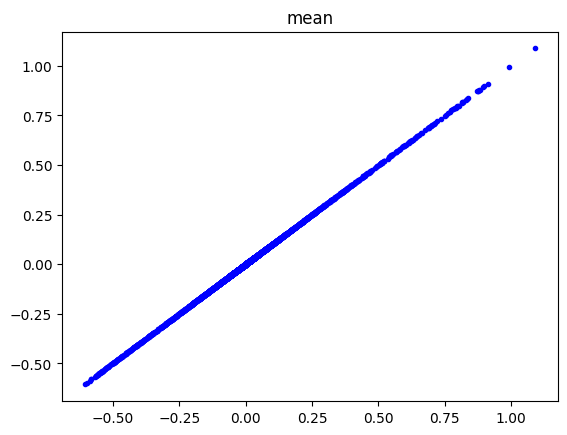

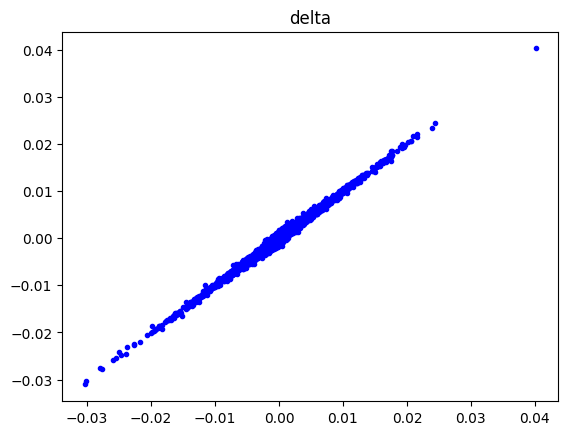

In [20]:
plt.plot((pred_nl[::2]+pred_nl[1::2])[ntrain//2:]/2, (target[::2]+target[1::2])[ntrain//2:]/2,'b.')
plt.title("mean")
plt.figure()
plt.plot((pred_nl[::2]-pred_nl[1::2])[ntrain//2:], (target[::2]-target[1::2])[ntrain//2:],'b.')
plt.title('delta')
print( 
    np.sqrt(np.mean( ((pred_nl[::2]+pred_nl[1::2]).flatten()[ntrain//2:]/2-(target[::2]+target[1::2]).flatten()[ntrain//2:]/2)**2 )) /np.std(target)
    ,
    np.sqrt(np.mean( ((pred_nl[::2]-pred_nl[1::2]).flatten()[ntrain//2:]-(target[::2]-target[1::2]).flatten()[ntrain//2:])**2 )) /np.std(target[::2]-target[1::2])     
     )

## Intermediate Energies

In [50]:
e0 = -198.27291671238572
from ase.io import read
import ast 
frames = read('bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz', ':8000')
for fi, f in enumerate(frames):
    f.info["energy_rel"] = (f.info["energy_ha"]-e0)#*Hartree
    for n, v in zip( ("index", "label","r", "z_1", "z_2", "psi", "phi_1", "phi_2"), ast.literal_eval(f.info["pars"]) ):
        f.info[n] = v 
    if fi%2 ==1:
        frames[fi].info["delta"] = np.abs(frames[fi].info["energy_rel"]-frames[fi-1].info["energy_rel"])
        frames[fi-1].info["delta"] = frames[fi].info["delta"]
energy = np.asarray([f.info["energy_rel"] for f in frames])

### from lin, lin decoder

In [178]:
pred_fromlinlin = np.load('bispectrum_counter/boron/pred_feat/energy/linlin_encoded_energy.npy')

In [179]:
fromlinlin_mean_train, fromlinlin_mean_val, fromlinlin_delta_train, fromlinlin_delta_val = get_all_errors(pred_fromlinlin[:7000], pred_fromlinlin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromlinlin_mean_train )
print("mean test error: ",fromlinlin_mean_val )
print("delta train error: ",fromlinlin_delta_train )
print("delta val train error: ",fromlinlin_delta_val )

target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.4102880759959699
mean test error:  0.39092258408261604
delta train error:  1.0000023733357435
delta val train error:  1.0001233914499326


In [180]:
fromlinlin_mean_train, fromlinlin_mean_val, fromlinlin_delta_train, fromlinlin_delta_val = get_all_errors(pred_fromlinlin[:7000], pred_fromlinlin[7000:], energy[:7000], energy[7000:],relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",fromlinlin_mean_train*Hartree)
print("mean test error: ",fromlinlin_mean_val*Hartree )
print("delta train error: ",fromlinlin_delta_train*Hartree )
print("delta val train error: ",fromlinlin_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.5759592795062207
mean test error:  1.667459562567401
delta train error:  0.2501269133409327
delta val train error:  0.24509101376412618


### lin encoder, non linear decoder

In [181]:
pred_fromlin = np.load('bispectrum_counter/boron/pred_feat/energy/lin_encoded_energy.npy')

In [182]:
fromlin_mean_train, fromlin_mean_val, fromlin_delta_train, fromlin_delta_val = get_all_errors(pred_fromlin[:7000], pred_fromlin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromlin_mean_train )
print("mean test error: ",fromlin_mean_val )
print("delta train error: ",fromlin_delta_train )
print("delta val train error: ",fromlin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.028345945048963726
mean test error:  0.1726140448410326
delta train error:  1.0000023680757848
delta val train error:  1.0001234075849286


In [183]:
fromlin_mean_train, fromlin_mean_val, fromlin_delta_train, fromlin_delta_val = get_all_errors(pred_fromlin[:7000], pred_fromlin[7000:], energy[:7000], energy[7000:],relative=False)

print("ABSOLUTE in eV")
print("mean train error: ",fromlin_mean_train*Hartree)
print("mean test error: ",fromlin_mean_val*Hartree )
print("delta train error: ",fromlin_delta_train*Hartree )
print("delta val train error: ",fromlin_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.10887973048655353
mean test error:  0.7362760593099674
delta train error:  0.2501269120252786
delta val train error:  0.24509101771818081


### from nl 

In [184]:
pred_fromnl = np.load('bispectrum_counter/boron/pred_feat/energy/nl_encoded_energy.npy')

In [185]:
fromnl_mean_train, fromnl_mean_val, fromnl_delta_train, fromnl_delta_val = get_all_errors(pred_fromnl[:7000], pred_fromnl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromnl_mean_train )
print("mean test error: ",fromnl_mean_val )
print("delta train error: ",fromnl_delta_train )
print("delta val train error: ",fromnl_delta_val )

target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.0015317472814490897
mean test error:  0.11033838259912912
delta train error:  0.048115292051536425
delta val train error:  0.45723273101822215


In [186]:
fromnl_mean_train, fromnl_mean_val, fromnl_delta_train, fromnl_delta_val = get_all_errors(pred_fromnl[:7000], pred_fromnl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",fromnl_mean_train *Hartree)
print("mean test error: ",fromnl_mean_val*Hartree )
print("delta train error: ",fromnl_delta_train*Hartree )
print("delta val train error: ",fromnl_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.005883601019108903
mean test error:  0.4706425227769797
delta train error:  0.012034900922487789
delta val train error:  0.11204980758317373


## Energies 

### lin

In [187]:
pred_lin = np.load('bispectrum_counter/boron/pred_energy/batchmc2_lin_triple_energy_LBFGS.npy')

In [188]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",lin_mean_train )
print("mean test error: ",lin_mean_val )
print("delta train error: ",lin_delta_train )
print("delta val train error: ",lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.41694461033341307
mean test error:  0.38510917844709885
delta train error:  1.0000023738252333
delta val train error:  1.0001233879584155


In [189]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",lin_mean_train *Hartree)
print("mean test error: ",lin_mean_val*Hartree )
print("delta train error: ",lin_delta_train*Hartree )
print("delta val train error: ",lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.6015277219548099
mean test error:  1.6426627889535803
delta train error:  0.2501269134633669
delta val train error:  0.24509101290849228


### nl

In [51]:
pred_nl = np.load('bispectrum_counter/boron/pred_energy/batchmc2_nl_triple_energy.npy')

In [191]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nl_mean_train )
print("mean test error: ",nl_mean_val )
print("delta train error: ",nl_delta_train )
print("delta val train error: ",nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.005046620069444155
mean test error:  0.01769675861276713
delta train error:  0.10702010166137249
delta val train error:  0.19968327419839013


In [192]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nl_mean_train*Hartree )
print("mean test error: ",nl_mean_val*Hartree )
print("delta train error: ",nl_delta_train*Hartree )
print("delta val train error: ",nl_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.01938459388388603
mean test error:  0.07548458589199677
delta train error:  0.026768544163249256
delta val train error:  0.04893453800142764


### nu7 lin

In [193]:
pred_nu7lin = np.load('bispectrum_counter/boron/pred_energy/nu7_lin_single_energy.npy')

In [194]:
nu7lin_mean_train, nu7lin_mean_val, nu7lin_delta_train, nu7lin_delta_val = get_all_errors(pred_nu7lin[:7000], pred_nu7lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7lin_mean_train )
print("mean test error: ",nu7lin_mean_val )
print("delta train error: ",nu7lin_delta_train )
print("delta val train error: ",nu7lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.0740768270424306
mean test error:  0.12722941060106222
delta train error:  0.5504812065564629
delta val train error:  0.8875893087214347


In [195]:
nu7lin_mean_train, nu7lin_mean_val, nu7lin_delta_train, nu7lin_delta_val = get_all_errors(pred_nu7lin[:7000], pred_nu7lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu7lin_mean_train *Hartree)
print("mean test error: ",nu7lin_mean_val *Hartree)
print("delta train error: ",nu7lin_delta_train *Hartree)
print("delta val train error: ",nu7lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.28453681645635387
mean test error:  0.5426903074541237
delta train error:  0.1376898382639458
delta val train error:  0.21751332419628416


### nu7 nl 

In [52]:
pred_nu7nl = np.load('bispectrum_counter/boron/pred_energy/nu7_nl_single_energy.npy')

In [197]:
nu7nl_mean_train, nu7nl_mean_val, nu7nl_delta_train, nu7nl_delta_val = get_all_errors(pred_nu7nl[:7000], pred_nu7nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7nl_mean_train )
print("mean test error: ",nu7nl_mean_val )
print("delta train error: ",nu7nl_delta_train )
print("delta val train error: ",nu7nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.045195934344062376
mean test error:  0.10036617514867005
delta train error:  0.21180563558062157
delta val train error:  0.431465478175408


In [198]:
nu7nl_mean_train, nu7nl_mean_val, nu7nl_delta_train, nu7nl_delta_val = get_all_errors(pred_nu7nl[:7000], pred_nu7nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu7nl_mean_train*Hartree )
print("mean test error: ",nu7nl_mean_val*Hartree )
print("delta train error: ",nu7nl_delta_train *Hartree)
print("delta val train error: ",nu7nl_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.17360229627092216
mean test error:  0.4281066004480213
delta train error:  0.05297816412102476
delta val train error:  0.1057352646226234


### nu7 lin lbfgs

In [199]:
pred_nu7lin_lbfgs = np.load('bisp/pred_energy/nu7_lin_single_energy_LBFGS.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'bisp/pred_energy/nu7_lin_single_energy_LBFGS.npy'

In [50]:
nu7lin_lbfgs_mean_train, nu7lin_lbfgs_mean_val, nu7lin_lbfgs_delta_train, nu7lin_lbfgs_delta_val = get_all_errors(pred_nu7lin_lbfgs[:7000], pred_nu7lin_lbfgs[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7lin_lbfgs_mean_train )
print("mean test error: ",nu7lin_lbfgs_mean_val )
print("delta train error: ",nu7lin_lbfgs_delta_train )
print("delta val train error: ",nu7lin_lbfgs_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.08903491931752884
mean test error:  0.1373534014579147
delta train error:  0.904477867149621
delta val train error:  1.349707934825516


### nu3 nl

In [53]:
pred_nu3nl = np.load('bispectrum_counter/boron/pred_energy/nu3_nl_single_energy.npy')

In [201]:
nu3nl_mean_train, nu3nl_mean_val, nu3nl_delta_train, nu3nl_delta_val = get_all_errors(pred_nu3nl[:7000], pred_nu3nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu3nl_mean_train )
print("mean test error: ",nu3nl_mean_val )
print("delta train error: ",nu3nl_delta_train )
print("delta val train error: ",nu3nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.03682488236125799
mean test error:  0.1686216609441584
delta train error:  1.000002365376443
delta val train error:  1.0001233624553367


In [202]:
nu3nl_mean_train, nu3nl_mean_val, nu3nl_delta_train, nu3nl_delta_val = get_all_errors(pred_nu3nl[:7000], pred_nu3nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu3nl_mean_train*Hartree )
print("mean test error: ",nu3nl_mean_val*Hartree )
print("delta train error: ",nu3nl_delta_train*Hartree )
print("delta val train error: ",nu3nl_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.141448212778476
mean test error:  0.7192467574037975
delta train error:  0.2501269113501021
delta val train error:  0.24509100665868805


## nu3 lin

In [203]:
pred_nu3lin = np.load('bispectrum_counter/boron/pred_energy/nu3_lin_single_energy.npy')

In [204]:
nu3lin_mean_train, nu3lin_mean_val, nu3lin_delta_train, nu3lin_delta_val = get_all_errors(pred_nu3lin[:7000], pred_nu3lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu3lin_mean_train )
print("mean test error: ",nu3lin_mean_val )
print("delta train error: ",nu3lin_delta_train )
print("delta val train error: ",nu3lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.4103645475787769
mean test error:  0.3890968069999996
delta train error:  1.0000023738550745
delta val train error:  1.0001233851570352


In [205]:
nu3lin_mean_train, nu3lin_mean_val, nu3lin_delta_train, nu3lin_delta_val = get_all_errors(pred_nu3lin[:7000], pred_nu3lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu3lin_mean_train*Hartree )
print("mean test error: ",nu3lin_mean_val*Hartree )
print("delta train error: ",nu3lin_delta_train*Hartree )
print("delta val train error: ",nu3lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.5762530148292633
mean test error:  1.6596718071920764
delta train error:  0.25012691347083105
delta val train error:  0.2450910122219839


In [55]:
ypred_n3 = pred_nu3nl
ypred = pred_nl #pred_fromnl

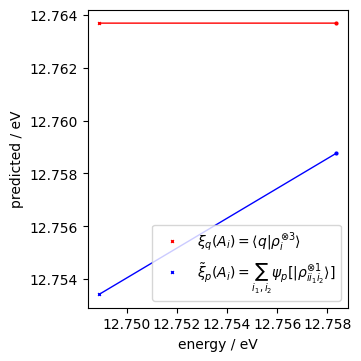

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)

ax.plot(np.hstack([energy[0:2:2],energy[1:2:2]])*Hartree, np.vstack([ypred_n3[:2:2],ypred_n3[1:2:2]])*Hartree,'r-', lw=1);
ax.plot(energy[0:2:2]*Hartree,ypred_n3[0:2:2]*Hartree,'r',ls="",marker='x',markersize=2, label=r"$\xi_q(A_i)=\langle q|\rho_i^{\otimes{3}}\rangle$");
ax.plot(energy[1:2:2]*Hartree,ypred_n3[1:2:2]*Hartree,'r',ls="",marker='o',markersize=2);

ax.plot(np.hstack([energy[:2:2],energy[1:2:2]])*Hartree, np.vstack([ypred[:2:2],ypred[1:2:2]])*Hartree,'b-', lw=1);
ax.plot(energy[0:2:2]*Hartree,ypred[0:2:2]*Hartree,'b',ls="",marker='x',markersize=2, label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$");
ax.plot(energy[1:2:2]*Hartree,ypred[1:2:2]*Hartree,'b',ls="",marker='o',markersize=2);

# ax.set_xlim(6,12)
# ax.set_ylim(6,12)
ax.set_xlabel('energy / eV')
ax.set_ylabel('predicted / eV')
ax.legend()

In [57]:
energy.shape

(8000,)

In [195]:
np.random.seed(45352)
idx = [np.random.randint(pair_bis.shape[0]) for _ in range(200000)]

In [196]:
alli = list(range(pair_bis.shape[0]))

In [204]:
idxj = np.setdiff1d(alli, idx)
idxk = np.setdiff1d(alli, idxj)
idxl = np.setdiff1d(idxk, idxj)

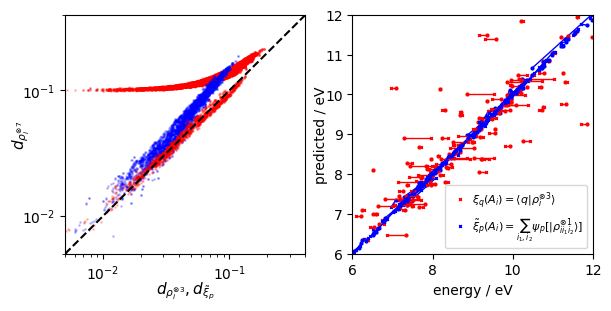

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
idx1=1
idx0=0

# ax[idx0].loglog(pair_enc_nl[:4000:2], pair_bis[:4000:2], c='navy', ls = '', marker = 'o', markersize =1, alpha=0.2)
# ax[idx0].loglog(pair_enc_nl5, pair_bis5, c='navy', ls = '', marker = 'o', markersize =1, alpha=0.2)
ax[idx0].loglog( pair_f7_nl, pair_bis, c='r', ls = '', marker = 'o', markersize =1, alpha=0.2,rasterized=True);# label = r"d$_{\rho_i^{\otimes{3}}}$");
ax[idx0].loglog( pair_enc_nl[:4000:2],pair_f7_nl[:4000:2], c='b', ls = '', marker = 'o', markersize =1, alpha=0.2,rasterized=True);# label = r"$d_{\tilde{\xi}_p}$");

# ax[idx0].loglog(pair_f7_nl[:1], pair_bis[:1], c='r', ls = '', marker = 'o', markersize =1, label = r"d$_{\rho_i^{\otimes{3}}}$");
# ax[idx0].loglog(pair_f7_nl[:1], pair_enc_nl[:1], c='b', ls = '', marker = 'o', markersize =1, label = r"$d_{\tilde{\xi}_p}$");

ax[idx0].loglog( pair_enc_nl5,pair_f7_nl5, c='b', ls = '', marker = 'o', markersize =1, alpha=0.2,rasterized=True)
ax[idx0].loglog(  pair_bis5,pair_f7_nl5,c='r', ls = '', marker = 'o', markersize =1, alpha=0.2,rasterized=True)

ax[idx0].set_ylabel(r'$d_{\rho_i^{\otimes{7}}}$', fontsize = 11, labelpad =-7)
ax[idx0].set_xlabel(r'$d_{\rho_i^{\otimes{3}}}, d_{\tilde{\xi}_p}$', fontsize = 11, labelpad =-2)
# ax[idx0].set_xlabel(r'$\tilde{\xi}_p(A_i)$', labelpad=-5)#' =\sum_{i_1,i_2}\psi_p^{NL}[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$')
# ax[idx0].set_ylabel(r'$| \rho_i^{\otimes{3}}\rangle $', labelpad=-10)

y0,y1 =5e-3, 4e-1

ax[idx0].plot(np.linspace(y0,y1,100), np.linspace(y0,y1,100), 'k--')
ax[idx0].set_xlim(y0,y1)
ax[idx0].set_ylim(y0, y1)
ax[idx0].set_yticks([y0, y1], minor=True, loc='right')
# ax[1].ticks=[]
# ax[idx0].legend(loc = 'upper left',fontsize=8.5,columnspacing=1, handletextpad=0.01)

for i in range(7000,7500,2):
    ax[idx1].plot(np.hstack([energy[i:i+2:2],energy[i+1:i+2:2]])*Hartree, np.vstack([ypred_n3[i+1:i+2:2],ypred_n3[i+1:i+2:2]])*Hartree,'r-', lw=1,rasterized=True);
    ax[idx1].plot(energy[i:i+2:2]*Hartree,ypred_n3[i:i+2:2]*Hartree,'r',ls="",marker='x',markersize=2);
    ax[idx1].plot(energy[i+1:i+2:2]*Hartree,ypred_n3[i+1:i+2:2]*Hartree,'r',ls="",marker='o',markersize=2);

    ax[idx1].plot(np.hstack([energy[i:i+2:2],energy[i+1:i+2:2]])*Hartree, np.vstack([ypred[i:i+2:2],ypred[i+1:i+2:2]])*Hartree,'b-', lw=1);
    ax[idx1].plot(energy[i:i+2:2]*Hartree,ypred[i:i+2:2]*Hartree,'b',ls="",marker='x',markersize=2);
    ax[idx1].plot(energy[i+1:i+2:2]*Hartree,ypred[i+1:i+2:2]*Hartree,'b',ls="",marker='o',markersize=2);

ax[idx1].plot(energy[i:i+2:2]*Hartree,ypred_n3[i:i+2:2]*Hartree,'r',ls="",marker='x',markersize=2, label=r"$\xi_q(A_i)=\langle q|\rho_i^{\otimes{3}}\rangle$");
ax[idx1].plot(energy[i+1:i+2:2]*Hartree,ypred_n3[i+1:i+2:2]*Hartree,'r',ls="",marker='o',markersize=2);

ax[idx1].plot(np.hstack([energy[i:i+2:2],energy[i+1:i+2:2]])*Hartree, np.vstack([ypred[i:i+2:2],ypred[i+1:i+2:2]])*Hartree,'b-', lw=1);
ax[idx1].plot(energy[i:i+2:2]*Hartree,ypred[i:i+2:2]*Hartree,'b',ls="",marker='x',markersize=2, label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$");

ax[idx1].set_xlim(6,12)
ax[idx1].set_ylim(6,12)
ax[idx1].set_xlabel('energy / eV')
ax[idx1].set_ylabel('predicted / eV', labelpad =-2)

ax[idx1].legend(loc = 'lower right',fontsize=8,columnspacing=1, handletextpad=0.01)
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from matplotlib.image import imread
# pic = imread('/Users/jigyasa/Downloads/j1.tga')
# imagebox = OffsetImage(pic, zoom = 0.1)
# ab = AnnotationBbox(imagebox, (1.2, 0.4), frameon = False)
# ax[1].add_artist(ab)

fig.savefig("boron-energies-sensitivity.svg", dpi=200)

In [82]:
from ase.io import read,write
frd = read('bispectrum_counter/boron/NOISE/asymm/boron8_distorted_frames_var1e-1.xyz',':')
write('./frame354N.xyz', frd[354])
fr = read('bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz',':')
write('./frame354.xyz', fr[354])

In [88]:
frd = read('/Users/jigyasa/frame-354N.xyz')

In [94]:
write('/Users/jigyasa/frame-354N.xyz', frd)

In [89]:
frd.positions+= np.random.normal(0, scale=1e-2)

In [81]:
write('./frame354N.xyz', frd[354])

# CARBON

In [34]:
ev_tokcalmol  = 23.0609

## train 8k cosmosrv

In [2]:
# import torch
# torch.set_default_dtype(torch.float64)
# torch.device= "cpu"
# device = "cpu"

In [36]:
np.std(energy_perat)*ev_tokcalmol

10.703690117881862

In [144]:
from ase.io import read
frames = read('/Users/jigyasa/scratch/bispectrum_counter/carbon/C_concatenated.xyz', ':')
energy_tot = np.array([f.info["energy"] for f in frames])
nat = np.array([len(f) for f in frames])
energy_perat = energy_tot/nat
ebase = frames[0].info['energy']/len(frames[0])
y = []
for f in frames:
    y.append(f.info['energy'] - ebase*len(f))
    f.info['energy_rel'] = y[-1]

energy = np.array([f.info["energy_rel"] for f in frames])
print(np.min(energy), np.max(energy))

-20.697736000000077 31.854233999999906


In [145]:
def mse_loss(pred, target):
    return np.sum((pred.flatten() - target.flatten()) ** 2)

def get_all(pred, target, ntrain, relative=False): 
    print("target min,max", target.min(),target.max() )
    ntest =len(target)-ntrain
    print("ntrain", ntrain, "ntest", ntest)
    train = np.sqrt(mse_loss(pred[:ntrain], target[:ntrain])/ntrain)
    test = np.sqrt(mse_loss(pred[ntrain:], target[ntrain:])/ntest)
    if relative: 
        train = train/np.std(target[:ntrain])
        test= test/np.std(target[ntrain:])
    return train, test

In [146]:
NTRAIN = 8000

In [147]:
pred_3c = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_triple_p0-nl.npy')
pred_3c_diff = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_triple_p0-nl-DIFF.npy')
pred_nu3 = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_single-NU3_asym-nl.npy')
pred_nu3_diff = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/batchmc2_single-NU3_asym-nl-DIFF.npy')
pred_nu2 = np.load('/Users/jigyasa/scratch/bispectrum_counter/carbon/fit_energy_n4l3/linearnu2-pred.npy')


In [148]:
pred_nu2 = pred_nu2.flatten()
energy_baselined = energy.copy().flatten()
energy_baselined = energy_baselined- pred_nu2
# energy_baselined = torch.tensor(energy)
print("baselined", energy.shape, np.min(energy_baselined), np.max(energy_baselined))

baselined (10000,) -9.179295461407596 7.51621137515386


In [149]:
get_all(pred_3c_diff, energy_baselined,NTRAIN)

target min,max -9.179295461407596 7.51621137515386
ntrain 8000 ntest 2000


(0.3920188434898392, 0.7255178848725554)

In [150]:
get_all(pred_nu3_diff, energy_baselined,NTRAIN)

target min,max -9.179295461407596 7.51621137515386
ntrain 8000 ntest 2000


(0.47096567089872415, 0.7535950057724944)

In [152]:
get_all(pred_3c_diff.flatten()+pred_nu2, energy,NTRAIN, relative=True)

target min,max -20.697736000000077 31.854233999999906
ntrain 8000 ntest 2000


(0.07464115901331385, 0.11895647990381514)

In [153]:
get_all(pred_nu3_diff.flatten()+pred_nu2, energy,NTRAIN, relative=True)

target min,max -20.697736000000077 31.854233999999906
ntrain 8000 ntest 2000


(0.08967279026288658, 0.12356002660849394)

In [160]:
aa = pred_3c_diff.flatten()+pred_nu2 
aa = np.array([aa[i]+ ebase*len(f) for i,f in enumerate(frames)])
print( get_all(aa, energy_tot,NTRAIN))
train, test = get_all(aa/nat, energy_tot/nat,NTRAIN)
print(train*ev_tokcalmol, test*ev_tokcalmol)

target min,max -3709.18372 -603.679469
ntrain 8000 ntest 2000
(0.3920188434898408, 0.7255178848725523)
target min,max -154.55650375 -150.91986725
ntrain 8000 ntest 2000
0.8155932626753943 0.8851750003480492


In [161]:
aa = pred_nu3_diff.flatten()+pred_nu2 
aa = np.array([aa[i]+ ebase*len(f) for i,f in enumerate(frames)])
print( get_all(aa, energy_tot,NTRAIN))
train, test =get_all(aa/nat, energy_tot/nat,NTRAIN)
print(train*ev_tokcalmol, test*ev_tokcalmol)

target min,max -3709.18372 -603.679469
ntrain 8000 ntest 2000
(0.47096567089872327, 0.7535950057724893)
target min,max -154.55650375 -150.91986725
ntrain 8000 ntest 2000
0.9658643835740262 0.9285587366769609


In [132]:
aa = pred_nu3_diff.flatten()+pred_nu2 
# aa = np.array([aa[i]+ ebase*len(f) for i,f in enumerate(frames)])

bb = pred_3c_diff.flatten()+pred_nu2 
# bb = np.array([bb[i]+ ebase*len(f) for i,f in enumerate(frames)])

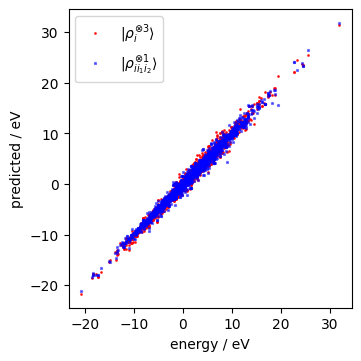

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)


ax.plot(energy[ntrain:], aa[ntrain:], 'r.',markersize=2,alpha = 0.8, label=r"$|\rho_i^{\otimes{3}}\rangle$" )
ax.plot(energy[ntrain:], bb[ntrain:], 'b*',markersize=2,alpha = 0.5,label=r"$|\rho_{ii_1 i_2}^{\otimes{1}}\rangle$")
ax.set_xlabel('energy / eV')
ax.set_ylabel('predicted / eV')

ax.legend()
fig.savefig("carbon-energies.pdf")

## log files on cosmopc

In [132]:
log_3nl = '/home/nigam/scratch/MAC/bispectrum_counter/carbon/train8k/fit_n4l3/log_nl_mc2batch'

In [159]:
epochs_3c = []
train_err_3c = []
val_err_3c = []
with open(log_3nl, 'r') as fp:
    for i, line in enumerate(fp):
#         print(i,line)
        if i>=19:
            line =line.split()
#             print(len(line),line)
            epoch, train, test = line[1], line[4], line[7]
            epochs_3c.append(int(epoch))
            train_err_3c.append(float(train))
            val_err_3c.append(float(test))
#             print(line[1], line[4], line[7])

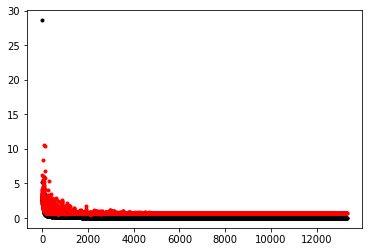

In [160]:
plt.plot(epochs_3c, train_err_3c, 'k.')
plt.plot(epochs_3c, val_err_3c, 'r.')

In [170]:
log_nu3 = '/home/nigam/scratch/MAC/bispectrum_counter/carbon/train8k/fit_n4l3/log_nu3_nl'

In [201]:
epochs_nu3 = []
train_err_nu3 = []
val_err_nu3 = []
with open(log_nu3, 'r') as fp:
    for i, line in enumerate(fp):

        if i>=29 and line.split()[0]=="epoch:":
            line =line.split()
#             print(i, len(line),line)
            epoch, train, test = line[1], line[4], line[7]
            epochs_nu3.append(int(epoch))
            train_err_nu3.append(float(train))
            val_err_nu3.append(float(test))
            
#             print(line[1], line[4], line[7])

In [202]:
len(epochs_nu3)

91575

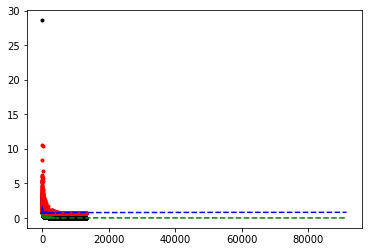

In [204]:
plt.plot(epochs_3c, train_err_3c, 'k.')
plt.plot(epochs_3c, val_err_3c, 'r.')

plt.plot(epochs_nu3, train_err_nu3, 'g--')
plt.plot(epochs_nu3, val_err_nu3, 'b--')

In [205]:
min(val_err_nu3)

0.6566914572992681

In [206]:
min(val_err_3c)

0.6432118160903881

In [210]:
np.where(np.isclose(val_err_3c,0.64321181609))

(array([708]),)

In [211]:
val_err_3c[708]

0.6432118160903881

## train 4k imx

In [120]:
from ase.io import read
frames = read('/home/nigam/scratch/MAC/bispectrum_counter/carbon/C_lessthan14.xyz', ':')
energy_tot = np.array([f.info["energy"] for f in frames])
nat = np.array([len(f) for f in frames])
energy_perat = energy_tot/nat
ebase = frames[0].info['energy']/len(frames[0])
y = []
for f in frames:
    y.append(f.info['energy'] - ebase*len(f))
    f.info['energy_rel'] = y[-1]

energy = np.array([f.info["energy_rel"] for f in frames])
print(np.min(energy), np.max(energy))

-36.15852571428604 16.39344428571394


In [92]:
ev_tokcalmol  = 23.0609

In [93]:
ntrain = 4000

In [94]:
def mse_loss(pred, target, ntrain, relative=False):
    ntest = len(pred)-ntrain
    print(ntrain, ntest)
    mse_train = np.sqrt(np.sum((pred[:ntrain].flatten() - target[:ntrain].flatten()) ** 2)/ntrain)
    mse_test = np.sqrt(np.sum((pred[ntrain:].flatten() - target[ntrain:].flatten()) ** 2)/ntest)
    if not relative:
        return mse_train, mse_test
    else: 
        return mse_train/np.std(target[:ntrain]), mse_test/np.std(target[ntrain:])
        
        

## n4l3rcut4

### 3c

In [111]:
pred_3cnl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3/batchmc2_triple_p0-nl.npy')

In [113]:
pred_3cnl_tot = np.asarray([pred_3cnl[i]+ebase*len(f) for i,f in enumerate(frames)])

In [115]:
pred_3cnl_tot= pred_3cnl_tot.reshape(4415,)

In [107]:
pred_3cnl/nat#.shape

array([ 0.01108433,  0.669016  , -0.33404045, ...,  0.08118218,
        0.06765755, -0.02917977])

In [116]:
mse_loss(pred_3cnl_tot/nat, energy_perat, ntrain)

4000 415


(0.013924743206945589, 0.05371149836091454)

In [123]:
0.42*ev_tokcalmol

9.685578

In [110]:
pred_3cnl/nat

array([ 0.01108433,  0.669016  , -0.33404045, ...,  0.08118218,
        0.06765755, -0.02917977])

In [121]:
np.mean(nat)

14.423027404818834

In [118]:
mse_loss(pred_3cnl_tot, energy_tot, ntrain)

4000 415


(0.11048783206404543, 0.4204881063911966)

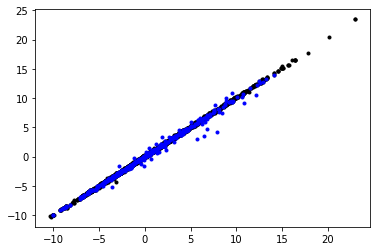

In [72]:
plt.plot(energy[:ntrain],pred_3cnl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_3cnl[ntrain:], 'b.')

In [73]:
mse_loss(pred_3cnl_tot, energy_tot, ntrain)
# mev_tokcalmol  

4000 415


(0.11048783206404543, 0.4204881063911966)

### nu3

In [32]:
pred_nu3nl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3/batchmc2_single-NU3_asym-nl.npy')

In [33]:
mse_loss(pred_nu3nl, energy, ntrain)

(0.10446067262314604, 0.3718448582007854)

In [34]:
pred_nu3nl_tot = np.asarray([pred_nu3nl[i]+ebase*len(f) for i,f in enumerate(frames)])

In [35]:
mse_loss(pred_nu3nl_tot, energy_tot, ntrain)

(0.10446067262314891, 0.37184485820078267)

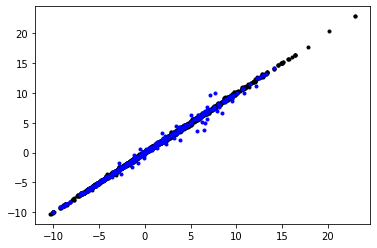

In [37]:
plt.plot(energy[:ntrain],pred_nu3nl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nl[ntrain:], 'b.')

### nu3 sum

In [45]:
pred_nu3nlsum = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3/batchmc2_single-NU3_asym-nl-SUM.npy')

In [46]:
mse_loss(pred_nu3nlsum, energy, ntrain)

(0.11579400908783584, 0.42626814864487306)

In [47]:
pred_nu3nlsum_tot = np.asarray([pred_nu3nlsum[i]+ebase*len(f) for i,f in enumerate(frames)])

In [48]:
mse_loss(pred_nu3nlsum_tot, energy_tot, ntrain)

(0.11579400908783721, 0.4262681486448721)

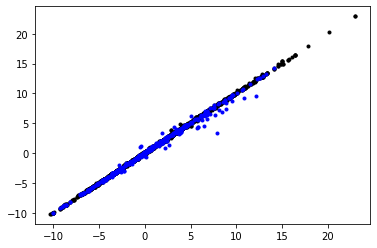

In [49]:
plt.plot(energy[:ntrain],pred_nu3nlsum[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nlsum[ntrain:], 'b.')

## n4l3rcut2.5

### 3c

In [38]:
pred_3cnl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3rcut2.5/batchmc2_triple_p0-nl.npy')

In [39]:
mse_loss(pred_3cnl, energy, ntrain)

(0.12855058399523922, 0.38007323422018136)

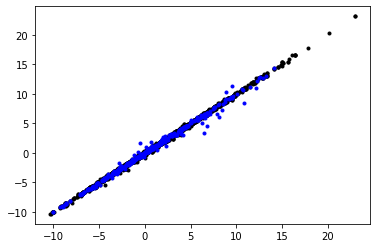

In [43]:
plt.plot(energy[:ntrain],pred_3cnl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_3cnl[ntrain:], 'b.')

### nu3

In [40]:
pred_nu3nl = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3rcut2.5/batchmc2_single-NU3_asym-nl.npy')

In [41]:
mse_loss(pred_nu3nl, energy, ntrain)

(0.10417165859354321, 0.3355311912005077)

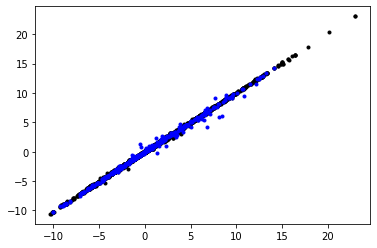

In [42]:
plt.plot(energy[:ntrain],pred_nu3nl[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nl[ntrain:], 'b.')

### nu3 sum

In [50]:
pred_nu3nlsum = np.load('/home/nigam/scratch/MAC/bispectrum_counter/carbon/train4k/fit_energy_n4l3rcut2.5/batchmc2_single-NU3_asym-nl-SUM.npy')

In [51]:
mse_loss(pred_nu3nlsum, energy, ntrain)

(0.066614718064105, 0.4072195873845343)

In [52]:
pred_nu3nlsum_tot = np.asarray([pred_nu3nlsum[i]+ebase*len(f) for i,f in enumerate(frames)])

In [53]:
mse_loss(pred_nu3nlsum_tot, energy_tot, ntrain)

(0.06661471806410689, 0.40721958738453706)

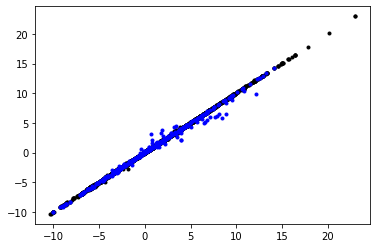

In [54]:
plt.plot(energy[:ntrain],pred_nu3nlsum[:ntrain], 'k.')
plt.plot(energy[ntrain:],pred_nu3nlsum[ntrain:], 'b.')

# CHECKS

In [ ]:
from ase.io import read, write
import hickle
from sklearn.decomposition import PCA 
import ase 
import json
from tqdm import tqdm
class tqdm_reusable:
    def __init__(self, *args, **kwargs):
        self._args = args
        self._kwargs = kwargs

    def __iter__(self):
        return tqdm(*self._args, **self._kwargs).__iter__()
import torch
import copy 
import numpy as np
import scipy as sp
from equistore.io import load,save
from equistore import Labels, TensorBlock, TensorMap
from itertools import product
from equistore_utils.clebsh_gordan import ClebschGordanReal
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations
import sys, os
sys.path.append(os.getcwd())
from feat_settings import *
cg = ClebschGordanReal(5)
from equistore_utils.mp_utils import *

import scipy
frames = read(frames_file, ":2")
print(len(frames))
#
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)
## selects only one environment
rho1i = operations.slice(rho1i, axis="samples", labels=Labels(['center'],np.array([[0]], np.int32)) )
# norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
# for b in rho1i.blocks():
#     b.values[:]/=norm_rho1
##print(np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean()))
#
calculator = PairExpansion(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, axis="samples", labels=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
norm_gij = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in gij.blocks()],axis=0).mean())
# for b in gij.blocks():
#     b.values[:]/=norm_gij

In [ ]:
test = operations.sum_over_samples(gij, sample_names=["neighbor"])
print("test (should be zero)", np.linalg.norm(rho1i.block(0).values/test.block(0).values -1))
#
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)


In [ ]:
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=lcut, other_keys_match=["species_center"])
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])

In [78]:
(np.linalg.norm(rho3i.block(0).values)**2+ np.linalg.norm(rho3i.block(1).values)**2)#/(norm_rho1**2)

0.9293165079625991

In [77]:
(np.linalg.norm(a.block(0).values)**2+np.linalg.norm(a.block(1).values)**2)#/(norm_gij**1)

1.0551691087322637